In [1]:
import robot_plotter as rp
import models_functions as mf
import traj
import numpy as np
import matplotlib.pyplot as plt
import robot_sim as sim
import sim_helper_funcs as hfunc
import save_load_data as sldat


In [2]:
# Now, load the all the data
dt=0.01
robData = []
datasets = ['no_collab_4anc_20d_meas2_noThres_Amb', 'no_collab_4anc_30d_meas2_noThres_Amb', 'no_collab_4anc_40d_meas2_noThres_Amb', 'no_collab_4anc_50d_meas2_noThres_Amb', 'collab_4anc_20d_meas2_noThres_Amb', 'collab_4anc_30d_meas2_noThres_Amb', 'collab_4anc_40d_meas2_noThres_Amb', 'collab_4anc_50d_meas2_noThres_Amb']
data_N = len(datasets)

for i in range(data_N):
    robData.append( sldat.load_object(datasets[i], folder=r"D:\msc_data") )

# We assume that all these parameters are identical for each dataset
# get number of robots
robot_N = robData[0].ids.shape[0]
# Get number of runs
runs_N = robData[0].biases.shape[2]
# Get length of runs 
pos_N = robData[0].pos.shape[2]

In [3]:
# Compute MAE and ANEES for all the datasets

anees_all = np.zeros((data_N, robot_N, pos_N))
anis_all = np.zeros((data_N, robot_N, pos_N))
err_pos = np.zeros((data_N, robot_N, 3, pos_N, runs_N))
err_bias = np.zeros((data_N, robot_N, 3, pos_N, runs_N))
MAE_all = np.zeros((data_N, robot_N, 2, pos_N)) # 2 because we track only the position and orientation error
MAE_bias = np.zeros((data_N, robot_N, 2, pos_N))

rad_sel = np.array([[True],[False],[False]])
rad_sel_ext = np.repeat(rad_sel, pos_N, axis=1)
pos_ind = [0, 1, 2]
bias_ind = [5, 6, 7]
prob = 0.997

for i in range(data_N):
    for j in range(robot_N):
        x_est=robData[i].x_log[j, pos_ind, :, :]
        x_true=robData[i].pos[j,0:3,:] 
        P = robData[i].P_log[j][pos_ind][:, pos_ind, :, :]

        # Compute anees
        temp_anees, t, r1, r2 = sim.ANEES(x_est=x_est, x_true=x_true, P=P, rad_sel=rad_sel, prob=prob, dt=dt)
        anees_all[i,j,:] = temp_anees

        # Compute anis
        df_nis = 2 
        temp_nis, t_nis, r1_2df, r2_2df = sim.ANIS(nis=robData[i].RB_nis_log[j], df=df_nis, dt=dt, prob=prob)
        anis_all[i,j,:] = temp_nis

        # Compute error 
        for k in range(runs_N):
            err_pos[i,j,:,:,k] = mf.subtractState(robData[i].pos[j], robData[i].x_log[j, pos_ind,:, k], rad_sel_ext) 
            err_bias[i,j,:,:,k] = robData[i].x_log[j, bias_ind,:, k] - np.repeat(robData[i].biases[j,:,k:k+1], pos_N, axis=1)
    
    # From the error, compute the MAE:
    MAE_all[i,:,0] =  (1/runs_N)*np.sum(np.linalg.norm(err_pos[i,:,1:], axis=1), axis=2)
    MAE_all[i,:,1] = (1/runs_N)*np.sum(abs(err_pos[i,:,0]), axis=2)
    MAE_bias[i,:,0] = (1/runs_N)*np.sum(np.linalg.norm(err_bias[i,:,1:], axis=1), axis=2)
    MAE_bias[i,:,1] = (1/runs_N)*np.sum(abs(err_bias[i,:,0]), axis=2)


In [4]:
# Average the ANEES and MAE across all six robots
MAE_mean = np.mean(MAE_all, axis=1)
ANEES_mean = np.mean(anees_all, axis=1)

Text(0.5, 1.03, 'UAVs with limited measurement range')

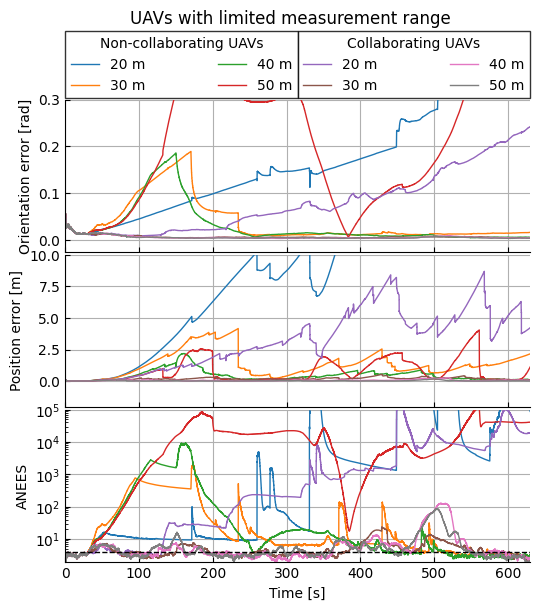

In [19]:
plt.rcParams['lines.linewidth'] = 1.0
fig, axerr = plt.subplots(3, figsize=(6,6), sharex=True)
fig.subplots_adjust(hspace=0.02)

names = ['20 m', '30 m', '40 m', '50 m', '20 m', '30 m', '40 m', '50 m']

# Plot the orientation error
for i in range(8):
    axerr[0].plot(t, MAE_mean[i, 1, :], label=names[i])
    axerr[1].plot(t, MAE_mean[i, 0, :])
    axerr[2].semilogy(t, ANEES_mean[i,:])

axerr[0].set_ylabel("Orientation error [rad]")
axerr[0].set_ylim([-0.025,0.3])
axerr[1].set_ylabel("Position error [m]")
axerr[1].set_ylim([-2,10])
axerr[2].set_ylabel("ANEES")
axerr[2].set_xlabel("Time [s]")
axerr[2].set_ylim([2,100])

# and thresholds
axerr[2].axhline(y=4.0256, color='black', linestyle='--')

# Common settings:
for i in range(3):
    axerr[i].grid()
    axerr[i].tick_params(direction='in', which='both')
    axerr[i].spines[['right', 'top']].set_visible(False)
    axerr[i].set_xlim([0,630])

# Setup legend
handles, labels = axerr[0].get_legend_handles_labels()
ref_handles = handles[:4]
ref_labels  = labels[:4]
act_handles = handles[4:]
act_labels  = labels[4:]
legend1 = axerr[0].legend(ref_handles, ref_labels, title="Non-collaborating UAVs", loc='upper left', ncols=2, borderaxespad=0., fancybox=False, edgecolor='black', bbox_to_anchor=(0.0, 1.02, 0.5, 0.43), mode='expand')
legend2 = axerr[0].legend(act_handles, act_labels, title="Collaborating UAVs", loc='upper left', ncols=2, borderaxespad=0., fancybox=False, edgecolor='black', bbox_to_anchor=(0.5, 1.02, 0.5, 0.43), mode = 'expand')
axerr[0].add_artist(legend1)

fig.suptitle('UAVs with limited measurement range', y=1.03)
#plt.savefig("non_ideal_anees.pdf", format="pdf", bbox_inches="tight")
#plt.tight_layout()